In [ ]:
!pip install pyod
!pip3 install scanpy
!pip install matplotlib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from pyod.models.cof import COF
from pyod.models.iforest import IForest
from pyod.models.ocsvm import OCSVM
from pyod.models.auto_encoder import AutoEncoder
from pyod.utils.example import visualize
from pyod.utils.data import evaluate_print
from pyod.utils.data import generate_data
from torchvision import datasets, transforms
from pyod.utils.utility import precision_n_scores
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, roc_auc_score, average_precision_score
from sklearn import metrics
from sklearn.metrics import precision_recall_curve, PrecisionRecallDisplay
from sklearn.metrics import roc_auc_score
import numpy as np
import pandas as pd
import csv

from sklearn.model_selection import train_test_split
normal_data = np.loadtxt('/content/drive/MyDrive/normal_X3D.csv', delimiter=',')
crash_data = np.loadtxt('/content/drive/MyDrive/crash_X3D.csv', delimiter=',')
# normal_label =np.loadtxt('/content/drive/MyDrive/normal_labeled_X3D.csv', delimiter=',', dtype='U4')
# crash_label = np.loadtxt('/content/drive/MyDrive/crash_labeled_X3D.csv', delimiter=',', dtype='U4')

In [ ]:
normal_label = pd.read_csv('/content/drive/MyDrive/normal_labeled_X3D.csv', header=None)
crash_label = pd.read_csv('/content/drive/MyDrive/crash_labeled_X3D.csv', header=None)

N_tr = np.round(normal_data.shape[0] * .7).astype(int)
test_data_label = normal_label.iloc[: , 0]
test_data_label = test_data_label[N_tr:]
test_data_label = pd.DataFrame(test_data_label).to_numpy()

C_tr = np.round(crash_data.shape[0] * .7).astype(int)
tmp_label = crash_label.iloc[: , 0]
tmp_label = tmp_label[C_tr:]
tmp_label = pd.DataFrame(tmp_label).to_numpy()

test_data_label = np.concatenate([test_data_label, tmp_label])
test_data_label.shape

(4025, 1)

In [ ]:
#### shuffling the label ####
# norm_data.shape (9000,512) crash_data.shape (2025,512)
# normal_data.shape (2523,512) super_crash.shape (65)
# crash anomaly is too many so, use only 300 of crash data (10% of normal data)
print('crash is', crash_data.shape)
crash_data = crash_data[1000:2000, :]
norm_data = normal_data[:, :]
# split 8:1 for training and testing
N = norm_data.shape[0]
N_tr = np.round(N * 7).astype(int)
train_data = norm_data[:N_tr, :] #normal - 4500
test_data = norm_data[N_tr:, :]  # normal - 450

#label - 0 = 'inlier'
train_label = np.zeros(train_data.shape[0])#,dtype="U4")
test_label = np.zeros(test_data.shape[0])#,dtype="U4")

C = crash_data.shape[0]
C_tr = np.round(C * .7).astype(int)

#label - 1 = 'outlier'
train_data = np.concatenate([train_data, crash_data[:C_tr, :]]) #anomaly - 500
tmp = np.ones(crash_data[:C_tr, :].shape[0])
train_label = np.concatenate([train_label, tmp])
# tmp = np.ones(crash_data[:, :].shape[0])
#tmp[:] = 'anomaly'

test_data = np.concatenate([test_data, crash_data[C_tr:, :]]) #anomaly - 50
tmp = np.ones(crash_data[C_tr:, :].shape[0])
#tmp[:] = 'anomaly'
test_label = np.concatenate([test_label, tmp])

train_data = np.insert(train_data, 0, train_label, axis=1)
test_data = np.insert(test_data, 0, test_label, axis=1)

np.random.shuffle(train_data)
np.random.shuffle(test_data)

train_label = train_data[:, 0]
test_label = test_data[:, 0]
np.delete(train_data, 0, 1)
np.delete(test_data, 0, 1)

print(train_data.shape, test_data.shape)

In [ ]:
# norm_data.shape (9000,512) crash_data.shape (2025,512)
# crash anomaly is too many so, use only 300 of crash data (10% of normal data)
#crash_data = crash_data[0:900, :]
norm_data = normal_data[:, :]
crash_data = crash_data[:1000, :]
# split 70% for training 30% for testing
N = norm_data.shape[0]
N_tr = np.round(N * 0.7).astype(int)
train_data = norm_data[:N_tr, :]
test_data = norm_data[N_tr:, :]
train_data_label = np.array(normal_label[:N_tr], dtype="U4")
test_data_label = np.array(normal_label[N_tr:], dtype="U4")

train_label = np.zeros(train_data.shape[0])#,dtype="U4")
#train_label[:] = 'normal'
test_label = np.zeros(test_data.shape[0])#,dtype="U4")
#test_label[:] = 'normal'

C = crash_data.shape[0]
C_tr = np.round(C * 0.7).astype(int)
# train_data = np.concatenate([train_data, crash_data[:C_tr, :]])
# tmp = np.ones(crash_data[:C_tr, :].shape[0])
train_data = np.concatenate([train_data, crash_data[:C_tr, :]])
tmp = np.ones(crash_data[:C_tr, :].shape[0])
#tmp[:] = 'anomaly'
train_label = np.concatenate([train_label, tmp])

#test_data = np.concatenate([test_data, crash_data[C_tr:, :]])
#tmp = np.ones(crash_data[C_tr:, :].shape[0])
test_data = np.concatenate([test_data, crash_data[C_tr:, :]])
tmp = np.ones(crash_data[C_tr:, :].shape[0])
#tmp[:] = 'anomaly'
test_label = np.concatenate([test_label, tmp])

train_data_label = np.concatenate([train_data_label, crash_label[:C_tr]])
test_data_label = np.concatenate([test_data_label, crash_label[C_tr:]])

print(train_data.shape, test_data.shape)
print(N, N_tr, C_tr)
train_data_label.shape

(6300, 2048) (3000, 2048)
9000 6300 700


(7000, 1)

In [ ]:
max_roc = 0
max_precision = 0
max_recall = 0
max_acc = 0
max_pred = np.zeros(test_label.shape[0])
max_scores = 0
max_train_pred = 0
max_train_scores = 0
max_i = 0
max_pr_auc = 0

classifier_name = 'IForest'
classifier = IForest(contamination = 0.1, n_estimators = 1001)
#classifier = AutoEncoder(hidden_neurons = [256, 128, 64, 3, 3, 64, 128, 256], contamination = 0.01, epochs=50, batch_size=100)
#classifier = OCSVM(degree = i, contamination = 0.06)
classifier.fit(train_data)

#array([0, 0, 0, ..., 0, 0, 0])
classifier.labels_

# get the prediction labels and outlier scores of the training data
y_train_pred = classifier.labels_ # binary labels (0: inliers, 1: outliers)
y_train_scores = classifier.decision_scores_ # raw outlier scores
y_train_scores.shape  #(2169,)

y_test_pred = classifier.predict(test_data)
y_test_scores = classifier.decision_function(test_data)

train_acc=np.round(accuracy_score(train_label, y_train_pred), decimals=3)
test_acc=np.round(accuracy_score(test_label, y_test_pred), decimals=3)
test_precision=np.round(precision_score(test_label, y_test_pred), decimals=3)
test_recall=np.round(recall_score(test_label, y_test_pred), decimals=3)

# evaluate and print the results
#print("\nOn Training Data:")
#print('accuracy :{acc}, '.format(acc=train_acc), end=' ')
#evaluate_print(classifier_name, train_label, y_train_scores)

print("\nOn Test Data:")
print('accuracy :{acc}, '.format(acc=test_acc), end=' ')
print('precision :{prec}, '.format(prec=test_precision), end=' ')
print('recall :{recall}, '.format(recall=test_recall), end=' ')
evaluate_print(classifier_name, test_label, y_test_scores)

print('\nMax is precision:{prec}, recall:{recall} '.format(prec=max_precision, recall=max_recall))
roc=np.round(roc_auc_score(test_label, y_test_scores), decimals=3)
pr_auc = average_precision_score(test_label, y_test_pred)
  
max_pr_auc

# On Test Data:
# 651 th : accuracy :0.994,  precision :0.961,  recall :0.98,  IForest ROC:0.9973, precision @ rank n:0.9633

# On Test Data:
# 1001 th : accuracy :0.994,  precision :0.964,  recall :0.98,  IForest ROC:0.9976, precision @ rank n:0.9633

# On Test Data:
# 1051 th : accuracy :0.994,  precision :0.958,  recall :0.983,  IForest ROC:0.9974, precision @ rank n:0.9633


On Test Data:
accuracy :0.995,  precision :0.964,  recall :0.987,  IForest ROC:0.9977, precision @ rank n:0.9633

Max is precision:0, recall:0 


0

In [ ]:
#사고인데 사고 아니라고한거 False Positive
#사고아닌데 사고라고 한거면 False Negative
fp = []
fn = []
tn = []
for i in range(len(y_test_pred)):
  if test_label[i] == 1 and y_test_pred[i] == 0:
    fp.append(test_data_label[i])
  elif test_label[i] == 0 and y_test_pred[i] == 1:
    fn.append(test_data_label[i])
  elif test_label[i] == 1 and y_test_pred[i] == 1:
    tn.append(test_data_label[i])


print('false positive:{pp}, false_negative:{ff}'.format(pp=len(fp), ff=len(fn)))
len(tn)
f1_score(test_label, y_test_pred)

false positive:4, false_negative:11


0.9752883031301481

In [ ]:
y_test_pred = np.loadtxt('/content/drive/MyDrive/y_pred_test.csv', delimiter=',')
#사고인데 사고 아니라고한거 False Positive
#사고아닌데 사고라고 한거면 False Negative
fp = []
fn = []
tn = []
for i in range(len(y_test_pred)):
  if test_label[i] == 1 and y_test_pred[i] == 0:
    fp.append(test_data_label[i])
  elif test_label[i] == 0 and y_test_pred[i] == 1:
    fn.append(test_data_label[i])
  elif test_label[i] == 1 and y_test_pred[i] == 1:
    tn.append(test_data_label[i])


print('false positive:{pp}, false_negative:{ff}'.format(pp=len(fp), ff=len(fn)))
len(tn)
f1_score(test_label, y_test_pred)

false positive:4, false_negative:11


0.9752883031301481

In [ ]:
fp.sort
for i in fp:
  print(i[0])

001043-2
001428-2
001341-2
000955-1


In [ ]:
40 / 65

0.6153846153846154

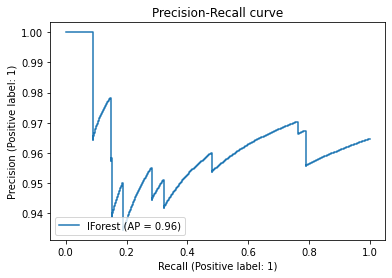

In [ ]:
from sklearn.metrics import PrecisionRecallDisplay

display = PrecisionRecallDisplay.from_predictions(test_label, y_test_pred, name="IForest")
_ = display.ax_.set_title("Precision-Recall curve")